In [1]:
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LassoCV
from sklearn.base import clone

%matplotlib inline

In [2]:
"""
2010-2018
Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p
Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p

2004-2018
Datasets/data_FEC_NATIONALPOLL_2004_2018.p
Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p
"""

'\n2010-2018\nDatasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p\nDatasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p\n\n2004-2018\nDatasets/data_FEC_NATIONALPOLL_2004_2018.p\nDatasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p\n'

(240, 2769)

(2769, 2769)

240

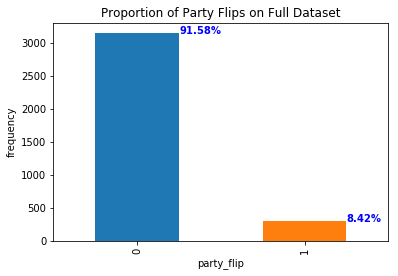

In [3]:
# Plot the proportion of flips in the full dataset

#read in FEC data
full_dataset = pickle.load(open('Datasets/data_FEC_NATIONALPOLL_2004_2018.p', 'rb'))
full_dataset_redistrict = pickle.load(open('Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p', 'rb'))

#add column to indicate a party flip
full_dataset['party_flip'] = (full_dataset.dem_win_prev!=full_dataset.dem_win)*1

#small_dataset.head()
plt.title('Proportion of districts that chage party in consecutive elections')
plt.ylabel('frequency')
plt.xlabel('Party Change')
full_dataset.party_flip.value_counts().plot(kind='bar')

#proportion of districts on the full data that do not flip
full_dataset.groupby('party_flip')['party_flip'].count().plot.bar()
plt.title('Proportion of Party Flips on Full Dataset')

for name, group in (full_dataset.groupby('party_flip')['party_flip']):
    plt.text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/full_dataset.shape[0]*100)+'%', color='blue', fontweight='bold')

C:\Users\m\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


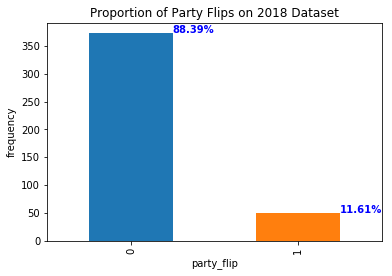

In [4]:
# Plot the proportion of flips in 2018

#add column to indicate a party flip
the_2018_dataset = full_dataset.loc[full_dataset['year']==2018,:]
the_2018_dataset.loc[:,'party_flip'] = (full_dataset.dem_win_prev!=full_dataset.dem_win)*1

#small_dataset.head()
plt.title('Proportion of districts that chage party in consecutive elections')
plt.ylabel('frequency')
plt.xlabel('Party Change')
the_2018_dataset.party_flip.value_counts().plot(kind='bar')

#proportion of districts on the full data that do not flip
the_2018_dataset.groupby('party_flip')['party_flip'].count().plot.bar()
plt.title('Proportion of Party Flips on 2018 Dataset')

for name, group in (the_2018_dataset.groupby('party_flip')['party_flip']):
    plt.text(int(name)+.25, group.count() + .25, \
    '{0:.2f}'.format(group.count()/the_2018_dataset.shape[0]*100)+'%', color='blue', fontweight='bold')

## Code without demographics

* district
* state
* year
* party
* candidatevotes
* totalvotes
* candidate
* national_poll
* national_poll_prev
* national_poll_delta_subtract
* national_poll_delta_divide
* previous_party
* dem_win_margin_prev
* rep_win_margin_prev
* margin_signed_minus_prev
* margin_signed_divide_prev
* margin_unsigned_minus_prev
* margin_unsigned_divide_prev
* dem_win_prev
* rep_win_prev
* dem_win
* rep_win

## Variables to use

* national_poll
* margin_signed_minus_prev

* dem_win -- response

### Functions

In [5]:
# format data items for input into the model

def format_model_input(filename, cols_to_use, state_hot_encoder=False):
    
    # load full dataset 
    full_dataset = pickle.load(open(filename, 'rb'))
    
    # train data is everything except 2018
    pre_2018_dataset = full_dataset.loc[full_dataset['year']!=2018]
    X_train = pre_2018_dataset[cols_to_use]
    y_train = pre_2018_dataset['dem_win']
    flip_train = np.abs(pre_2018_dataset['dem_win']-pre_2018_dataset['dem_win_prev'])
    
    # test data is 2018
    the_2018_dataset = full_dataset.loc[full_dataset['year']==2018]
    X_test = the_2018_dataset[cols_to_use]
    y_test = the_2018_dataset['dem_win']
    flip_test = np.abs(the_2018_dataset['dem_win']-the_2018_dataset['dem_win_prev'])
    
    if state_hot_encoder:
        #add one hot encoder for states (with or without dropping first)
        X_train.loc[:,'state'] = pre_2018_dataset['state']
        X_train = pd.get_dummies(X_train,prefix='state',columns=['state'], drop_first=True)
        X_test.loc[:,'state'] = the_2018_dataset['state']
        X_test = pd.get_dummies(X_test,prefix='state',columns=['state'], drop_first=True)
    
    return X_train,y_train, X_test,y_test, flip_train,flip_test

In [30]:
# plot flips predicted by a model

def plot_flips(X_test_input, y_test_input, y_pred_test_input, flip_train, 
               flip_test, model_name):
    
    # copy arrays so you don't accidentally change them 
    X_test = X_test_input.copy()
    y_test = y_test_input.copy()
    y_pred_test = y_pred_test_input.copy()
    
    # add flip data to the array
    X_test['party_flip'] = flip_test
    
    #looking at the missclassifications with logisticRegressionCV
    miss_class_df = X_test[y_test != y_pred_test]
    good_class_df = X_test[y_test == y_pred_test]

    #plot the flips and non flips for each data
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    ax[0].set_title(model_name+' Proportion of party flips on wellclassified test data')
    ax[1].set_title(model_name+' Proportion of party flips missclassified test data')

    if not good_class_df.empty:
        good_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[0])
        for name, group in (good_class_df.groupby('party_flip')['party_flip']):
            ax[0].text(int(name)+.25, group.count() + .25, \
            '{0:.2f}'.format(group.count()/good_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

    if not miss_class_df.empty:
        miss_class_df.groupby('party_flip')['party_flip'].count().plot.bar(ax=ax[1])
        for name, group in (miss_class_df.groupby('party_flip')['party_flip']):
            ax[1].text(int(name)+.15, group.count() + .25, \
            '{0:.2f}'.format(group.count()/miss_class_df.shape[0]*100)+'%', color='blue', fontweight='bold')

    normnoflip = len(X_test[X_test['party_flip'] == 0])
    normflip = len(X_test[X_test['party_flip'] == 1])
    print('predicted correctly. does not flip.: {}'.format(len(good_class_df[good_class_df['party_flip'] == 0])/normnoflip))
    print('predicted wrongly. does not flip.: {}'.format(len(miss_class_df[miss_class_df['party_flip'] == 0])/normnoflip))
    
    print('predicted correctly. does flips.: {}'.format(len(good_class_df[good_class_df['party_flip'] == 1])/normflip))
    print('predicted wrongly. does flips.: {}'.format(len(miss_class_df[miss_class_df['party_flip'] == 1])/normflip))
            
    plt.show()

In [44]:
# print out R2, accuracy, and plot # flipped seats correctly predicted for a given model

def report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder=False):
    
    # read in the desired data
    X_train,y_train, X_test,y_test, flip_train,flip_test = \
        format_model_input(filename, cols_to_use, state_hot_encoder)
        
    fitted_model_dict = {}
    
    print(X_train.shape)
    
    for model_name, model in model_dict.items():
        model_copy = clone(model) # deep copy model to prevent fitting it twice
        print(model_name)

        fitted_model = model_copy.fit(X_train,y_train)
        y_pred_test = fitted_model.predict(X_test)

        print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred_test.round()))

        print("\n{} R2: ".format(model_name), fitted_model.score(X_train,y_train))
        print("{} Test Accuracy".format(model_name), accuracy_score(y_test,y_pred_test.round()))

        plot_flips(X_test, y_test, y_pred_test.round(), flip_train, flip_test, model_name)
        
        fitted_model_dict[model_name] = fitted_model
        
    print('LASSO Betas')
    print([i for i in zip(cols_to_use,fitted_model_dict['LASSO'].coef_)])
    
    return fitted_model_dict

### Try out different models and columns

#### Full dataset, no demographics, not dropping any data. 

In [32]:
# specify your models here:
model_dict = {
    'LogRegCV'      : LogisticRegressionCV(cv=5,random_state=209,multi_class='ovr',n_jobs=4),
    'kNN'           : KNeighborsClassifier(n_neighbors=1,n_jobs=4),
    'Random Forest' : RandomForestClassifier(n_jobs=4,random_state=209),
    'AdaBoost'      : AdaBoostClassifier(DecisionTreeClassifier(max_depth=2)),
    'LASSO'         : LassoCV(cv=5)
}

C:\Users\m\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\m\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


LogRegCV
Confusion Matrix: 
 [[179  17]
 [ 23 203]]

LogRegCV R2:  0.8570953805250914
LogRegCV Test Accuracy 0.9052132701421801
predicted correctly. does not flip.: 0.967828418230563
predicted wrongly. does not flip.: 0.032171581769437
predicted correctly. does flips.: 0.42857142857142855
predicted wrongly. does flips.: 0.5714285714285714


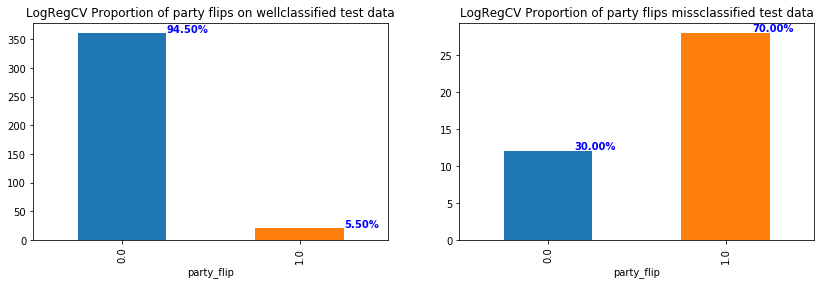

kNN
Confusion Matrix: 
 [[168  28]
 [ 37 189]]

kNN R2:  1.0
kNN Test Accuracy 0.8459715639810427
predicted correctly. does not flip.: 0.9329758713136729
predicted wrongly. does not flip.: 0.06702412868632708
predicted correctly. does flips.: 0.1836734693877551
predicted wrongly. does flips.: 0.8163265306122449


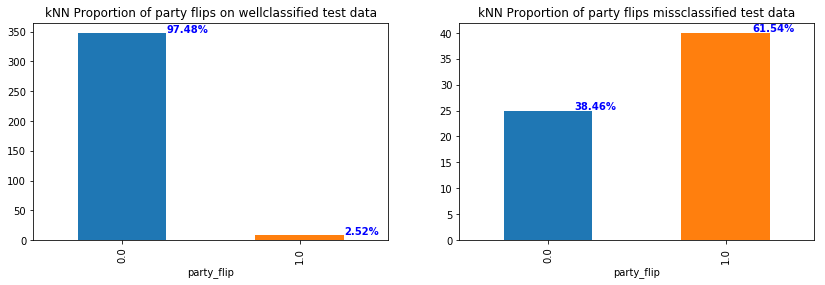

Random Forest
Confusion Matrix: 
 [[191   5]
 [ 44 182]]

Random Forest R2:  0.9890329012961117
Random Forest Test Accuracy 0.8838862559241706
predicted correctly. does not flip.: 1.0
predicted wrongly. does not flip.: 0.0
predicted correctly. does flips.: 0.0
predicted wrongly. does flips.: 1.0


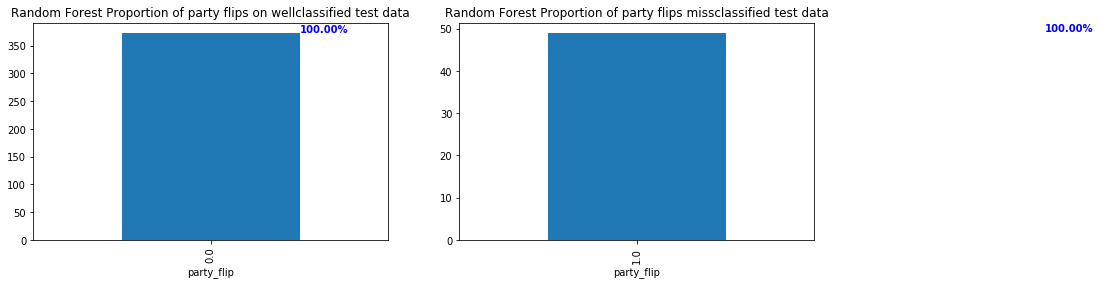

AdaBoost
Confusion Matrix: 
 [[187   9]
 [ 42 184]]

AdaBoost R2:  0.9468261881023596
AdaBoost Test Accuracy 0.8791469194312796
predicted correctly. does not flip.: 0.9865951742627346
predicted wrongly. does not flip.: 0.013404825737265416
predicted correctly. does flips.: 0.061224489795918366
predicted wrongly. does flips.: 0.9387755102040817


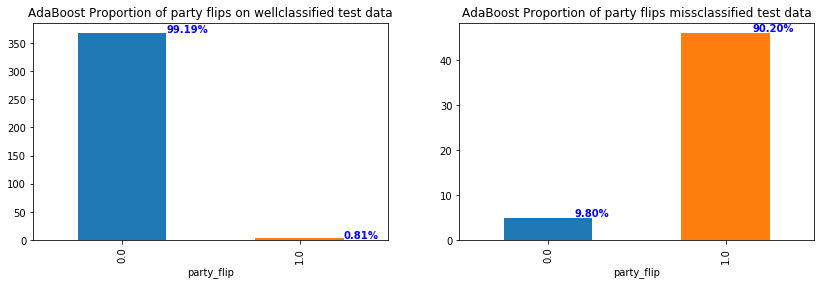

LASSO
Confusion Matrix: 
 [[195   1]
 [223   3]]

LASSO R2:  0.025471721521864388
LASSO Test Accuracy 0.46919431279620855
predicted correctly. does not flip.: 0.5201072386058981
predicted wrongly. does not flip.: 0.47989276139410186
predicted correctly. does flips.: 0.08163265306122448
predicted wrongly. does flips.: 0.9183673469387755


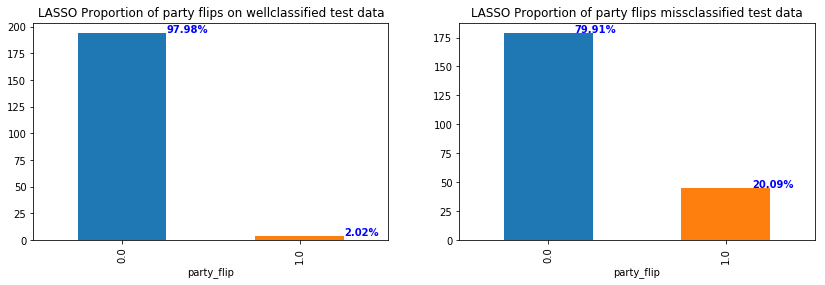

LASSO Betas
[('national_poll', 0.0), ('national_poll_prev', 0.0), ('national_poll_delta_subtract', 0.0), ('national_poll_delta_divide', 0.0), ('dem_win_margin_prev', 0.0), ('rep_win_margin_prev', -0.0), ('margin_signed_minus_prev', 0.0), ('margin_signed_divide_prev', 9.308300426489065e-11), ('margin_unsigned_minus_prev', 0.0), ('margin_unsigned_divide_prev', -4.5811265994974285e-11), ('dem_win_prev', 0.0), ('rep_win_prev', -0.0)]


{'LogRegCV': LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
            fit_intercept=True, intercept_scaling=1.0, max_iter=100,
            multi_class='ovr', n_jobs=4, penalty='l2', random_state=209,
            refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0),
 'kNN': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=4, n_neighbors=1, p=2,
            weights='uniform'),
 'Random Forest': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
             oob_score=False, random_state=209, verbose=0, warm_start=False),
 'AdaBoost': AdaBoostClassifier(algorithm='SAMME.R',
           base_estimator=DecisionTreeClas

In [33]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018.p'
cols_to_use = ['national_poll', 'national_poll_prev',
       'national_poll_delta_subtract', 'national_poll_delta_divide',
       'dem_win_margin_prev', 'rep_win_margin_prev',
       'margin_signed_minus_prev', 'margin_signed_divide_prev',
       'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev',
       'dem_win_prev', 'rep_win_prev'] # all of them

report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder=True,)

### Full dataset, no demographics, dropping redistricted states

LogRegCV
Confusion Matrix: 
 [[185   2]
 [ 37 180]]

LogRegCV R2:  0.9358432577794852
LogRegCV Test Accuracy 0.9034653465346535
predicted correctly. does not flip.: 1.0
predicted wrongly. does not flip.: 0.0
predicted correctly. does flips.: 0.0
predicted wrongly. does flips.: 1.0


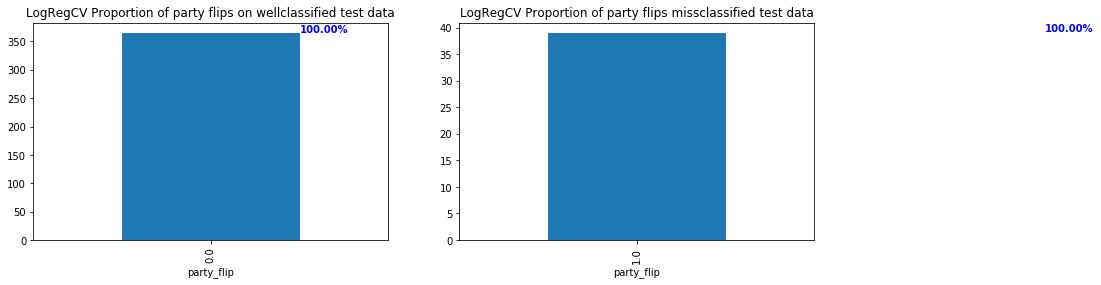

kNN
Confusion Matrix: 
 [[164  23]
 [ 29 188]]

kNN R2:  0.9992316557817903
kNN Test Accuracy 0.8712871287128713
predicted correctly. does not flip.: 0.9397260273972603
predicted wrongly. does not flip.: 0.06027397260273973
predicted correctly. does flips.: 0.23076923076923078
predicted wrongly. does flips.: 0.7692307692307693


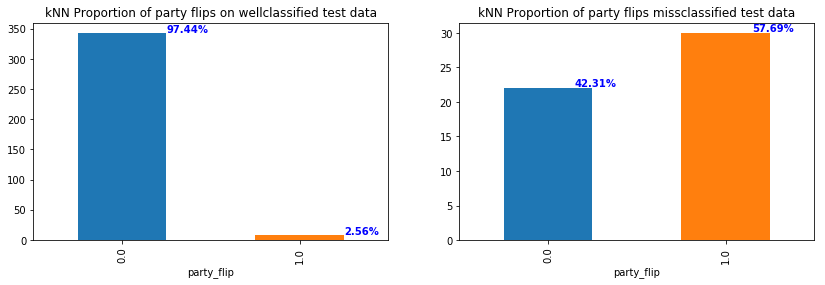

Random Forest
Confusion Matrix: 
 [[185   2]
 [ 37 180]]

Random Forest R2:  0.990395697272378
Random Forest Test Accuracy 0.9034653465346535
predicted correctly. does not flip.: 1.0
predicted wrongly. does not flip.: 0.0
predicted correctly. does flips.: 0.0
predicted wrongly. does flips.: 1.0


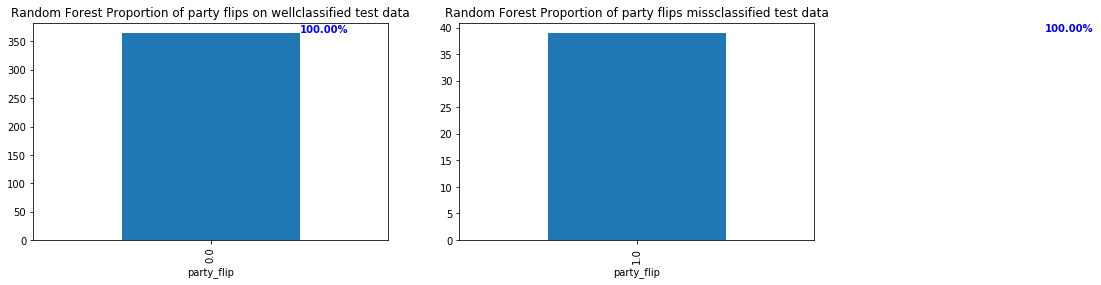

AdaBoost
Confusion Matrix: 
 [[176  11]
 [ 33 184]]

AdaBoost R2:  0.9750288129081829
AdaBoost Test Accuracy 0.8910891089108911
predicted correctly. does not flip.: 0.9753424657534246
predicted wrongly. does not flip.: 0.024657534246575342
predicted correctly. does flips.: 0.10256410256410256
predicted wrongly. does flips.: 0.8974358974358975


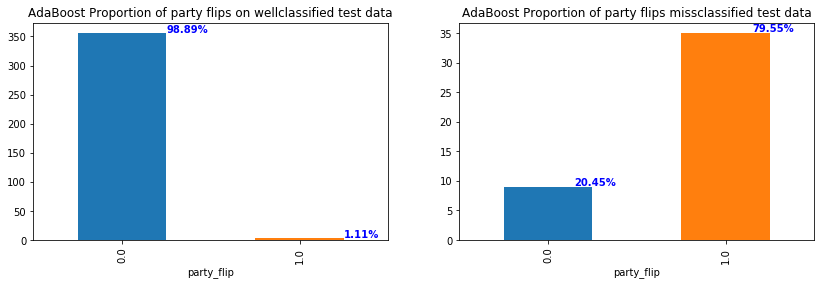

LASSO
Confusion Matrix: 
 [[187   0]
 [214   3]]

LASSO R2:  0.025571370567853413
LASSO Test Accuracy 0.47029702970297027
predicted correctly. does not flip.: 0.5150684931506849
predicted wrongly. does not flip.: 0.4849315068493151
predicted correctly. does flips.: 0.05128205128205128
predicted wrongly. does flips.: 0.9487179487179487


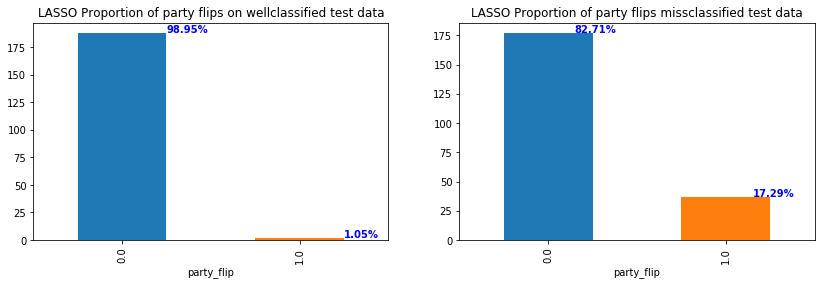

LASSO Betas
[('national_poll', 0.0), ('national_poll_prev', 0.0), ('national_poll_delta_subtract', 0.0), ('national_poll_delta_divide', 0.0), ('dem_win_margin_prev', 0.0), ('rep_win_margin_prev', -0.0), ('margin_signed_minus_prev', 0.0), ('margin_signed_divide_prev', 9.47203097821942e-11), ('margin_unsigned_minus_prev', 0.0), ('margin_unsigned_divide_prev', -4.821442596317747e-11), ('dem_win_prev', 0.0), ('rep_win_prev', -0.0)]


In [34]:
# specify columns to use and the file you want to read in 
filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p'
state_hot_encoder = False # some states get dropped so this leads to problems
# cols_to_use same as above

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder,)

### Selected columns in the full dataset, no demographics

LogRegCV
Confusion Matrix: 
 [[189   7]
 [ 42 184]]

LogRegCV R2:  0.9189099368560983
LogRegCV Test Accuracy 0.8838862559241706


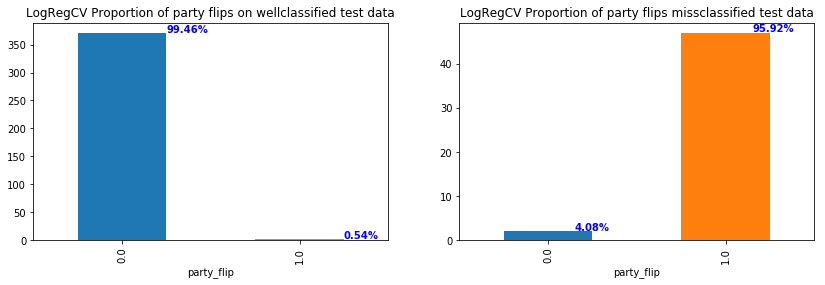

kNN
Confusion Matrix: 
 [[191   5]
 [ 39 187]]

kNN R2:  0.9302093718843469
kNN Test Accuracy 0.8957345971563981


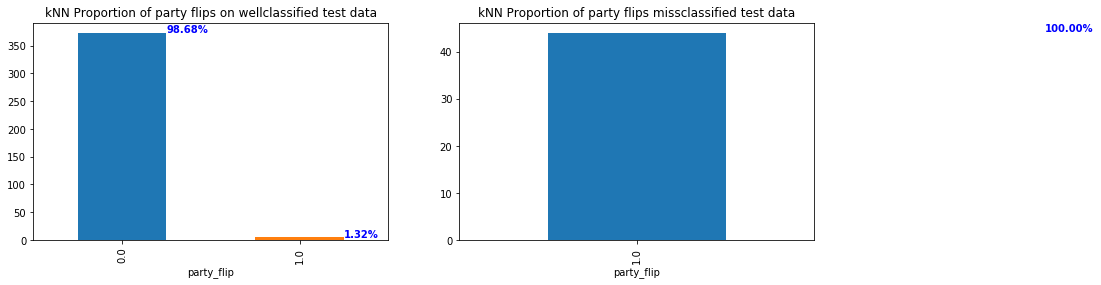

Random Forest
Confusion Matrix: 
 [[186  10]
 [ 39 187]]

Random Forest R2:  0.9827185111332669
Random Forest Test Accuracy 0.8838862559241706


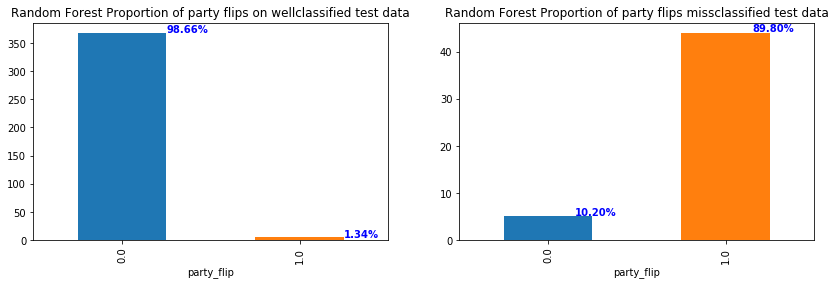

AdaBoost
Confusion Matrix: 
 [[189   7]
 [ 40 186]]

AdaBoost R2:  0.940844134263875
AdaBoost Test Accuracy 0.8886255924170616


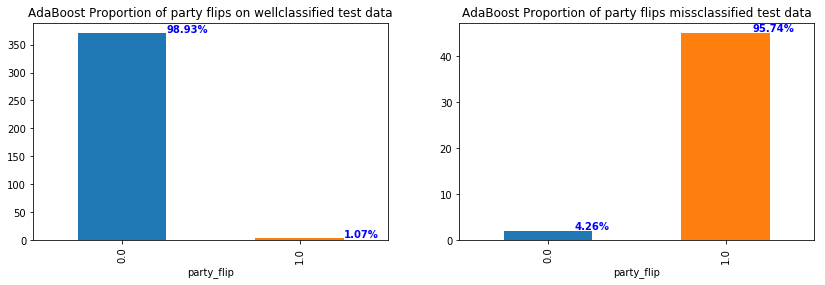

LASSO
Confusion Matrix: 
 [[191   5]
 [ 44 182]]

LASSO R2:  0.584087683966801
LASSO Test Accuracy 0.8838862559241706


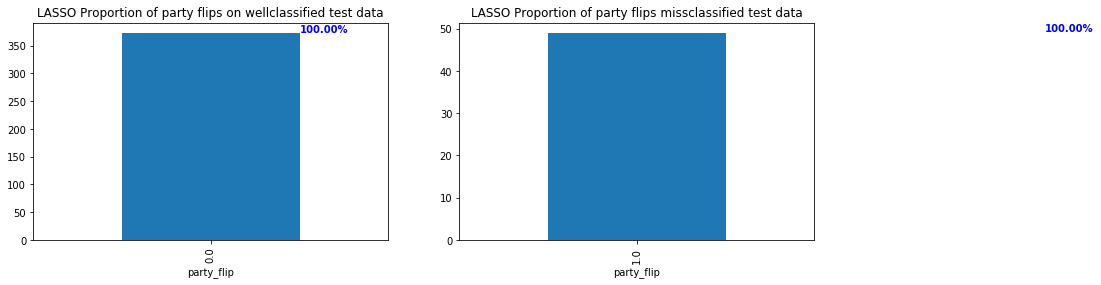

LASSO Betas
[('national_poll', 0.011005599159538868), ('margin_signed_minus_prev', 0.875433045484189)]


In [19]:
filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev']
state_hot_encoder = False

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

### Selected columns in the full dataset, no demographics, dropping redistricted states

LogRegCV
Confusion Matrix: 
 [[183   4]
 [ 32 185]]

LogRegCV R2:  0.933154053015751
LogRegCV Test Accuracy 0.9108910891089109


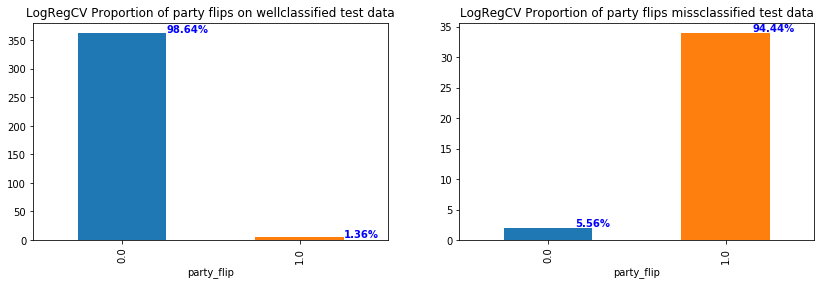

kNN
Confusion Matrix: 
 [[185   2]
 [ 32 185]]

kNN R2:  0.9466000768344218
kNN Test Accuracy 0.9158415841584159


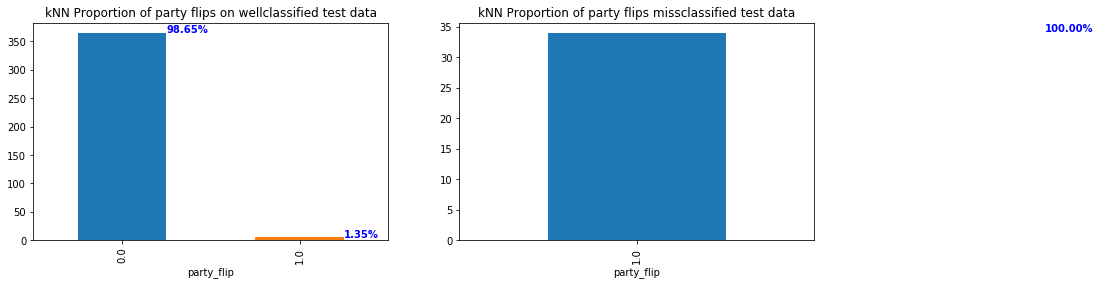

Random Forest
Confusion Matrix: 
 [[181   6]
 [ 33 184]]

Random Forest R2:  0.9880906646177487
Random Forest Test Accuracy 0.9034653465346535


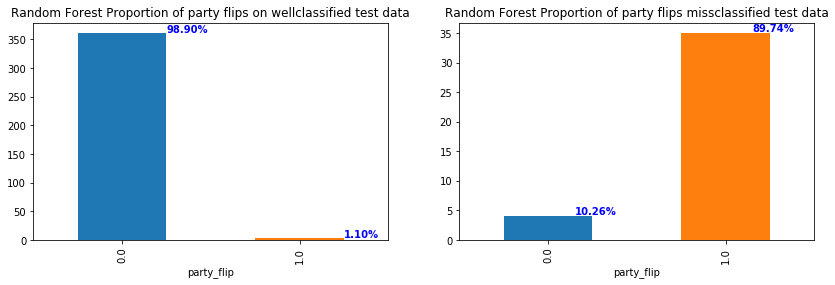

AdaBoost
Confusion Matrix: 
 [[181   6]
 [ 35 182]]

AdaBoost R2:  0.9631194775259316
AdaBoost Test Accuracy 0.8985148514851485


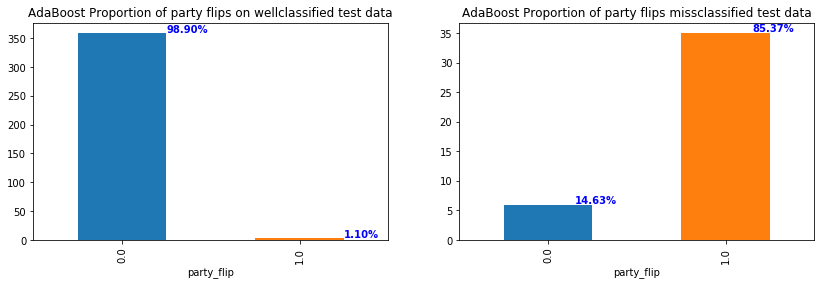

LASSO
Confusion Matrix: 
 [[185   2]
 [ 37 180]]

LASSO R2:  0.6220837467693127
LASSO Test Accuracy 0.9034653465346535


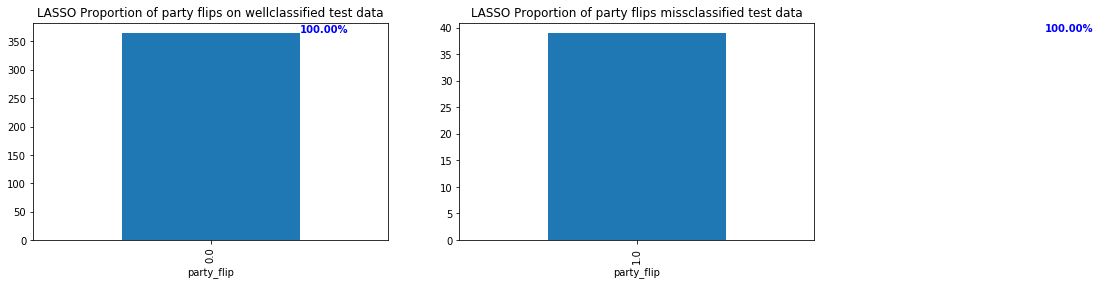

LASSO Betas
[('national_poll', 0.011608905044385318), ('margin_signed_minus_prev', 0.911246418646463)]


In [12]:
filename = 'Datasets/data_FEC_NATIONALPOLL_2004_2018_REDISTRICTDROP.p'
cols_to_use = ['national_poll', 'margin_signed_minus_prev']
state_hot_encoder = False

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

### Selected columns in the full dataset, no demographics, imputing redistricted states

### Dataset since 2010, with demographics, nothing dropped

columns in demographics


['district', 'state', 'year', 'party', 'candidatevotes', 'totalvotes',
       'candidate', 'national_poll', 'national_poll_prev',
       'national_poll_delta_subtract', 'national_poll_delta_divide',
       'previous_party', 'dem_win_margin_prev', 'rep_win_margin_prev',
       'margin_signed_minus_prev', 'margin_signed_divide_prev',
       'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev',
       'dem_win_prev', 'rep_win_prev', 'dem_win', 'rep_win', 'female_pct',
       'age18_24_pct', 'age25_34_pct', 'median_age', 'unmarried_partner_pct',
       'male_living_alone_pct', 'bachelors_deg_or_higher_pct',
       'past_year_births_to_unmarried_women_pct', 'civilian_veteran_pct',
       'live_same_house_past_year_pct',
       'foreign_born_proportion_from_LatinAmerica',
       'speak_other_language_at_home_pct', 'labor_force_unemployed_pct',
       'public_transit_commuter_pct', 'no_health_insurance_pct',
       'poverty_rate_pct', 'median_housing_value', 'median_household_income',
       'food_stamp_benefits_pct', 'foreign_to_native_born_ratio']

In [69]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
# cols_to_use = ['national_poll', 'national_poll_prev', 'national_poll_delta_subtract', 
#                'national_poll_delta_divide', 'dem_win_margin_prev', 'rep_win_margin_prev',
#                'margin_signed_minus_prev', 'margin_signed_divide_prev', 
#                'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev', 
#                'dem_win_prev', 'rep_win_prev', 'female_pct', 'age18_24_pct', 
#                'age25_34_pct', 'median_age', 'unmarried_partner_pct', 
#                'male_living_alone_pct', 'bachelors_deg_or_higher_pct', 
#                'past_year_births_to_unmarried_women_pct', 'civilian_veteran_pct', 
#                'live_same_house_past_year_pct', 
#                'foreign_born_proportion_from_LatinAmerica', 
#                'speak_other_language_at_home_pct', 'labor_force_unemployed_pct', 
#                'public_transit_commuter_pct', 'no_health_insurance_pct', 
#                'poverty_rate_pct', 'median_housing_value', 'median_household_income', 
#                'food_stamp_benefits_pct', 'foreign_to_native_born_ratio'] # everything
cols_to_use = ['national_poll', 'national_poll_prev', 'national_poll_delta_subtract', 
               'national_poll_delta_divide', 'dem_win_margin_prev', 'rep_win_margin_prev',
               'margin_signed_minus_prev', 'margin_signed_divide_prev', 
               'margin_unsigned_minus_prev', 'margin_unsigned_divide_prev', 
               'dem_win_prev', 'rep_win_prev', 'female_pct', 'age18_24_pct', 
               'age25_34_pct', 'median_age', 'unmarried_partner_pct', 
               'male_living_alone_pct', 'bachelors_deg_or_higher_pct'] # everything

C:\Users\m\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\m\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(1704, 68)
LogRegCV
Confusion Matrix: 
 [[186  10]
 [ 33 193]]

LogRegCV R2:  0.846830985915493
LogRegCV Test Accuracy 0.8981042654028436
predicted correctly. does not flip.: 0.9865951742627346
predicted wrongly. does not flip.: 0.013404825737265416
predicted correctly. does flips.: 0.22448979591836735
predicted wrongly. does flips.: 0.7755102040816326


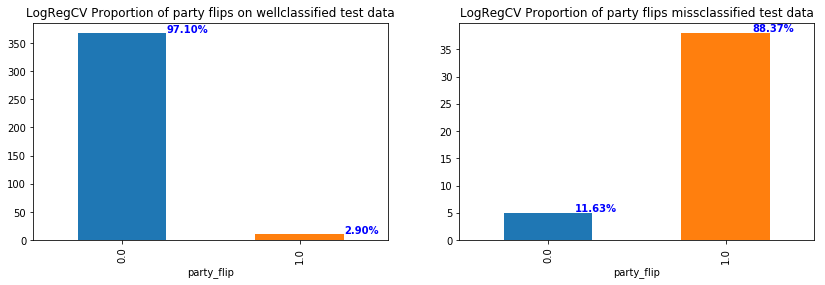

kNN
Confusion Matrix: 
 [[190   6]
 [ 45 181]]

kNN R2:  1.0
kNN Test Accuracy 0.8791469194312796
predicted correctly. does not flip.: 0.9919571045576407
predicted wrongly. does not flip.: 0.00804289544235925
predicted correctly. does flips.: 0.02040816326530612
predicted wrongly. does flips.: 0.9795918367346939


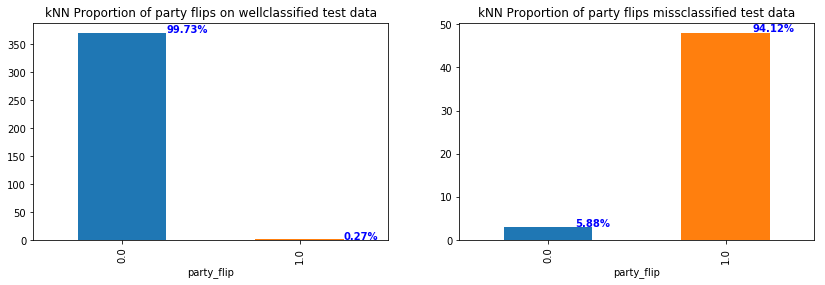

Random Forest
Confusion Matrix: 
 [[193   3]
 [ 46 180]]

Random Forest R2:  0.9953051643192489
Random Forest Test Accuracy 0.8838862559241706
predicted correctly. does not flip.: 0.9946380697050938
predicted wrongly. does not flip.: 0.005361930294906166
predicted correctly. does flips.: 0.04081632653061224
predicted wrongly. does flips.: 0.9591836734693877


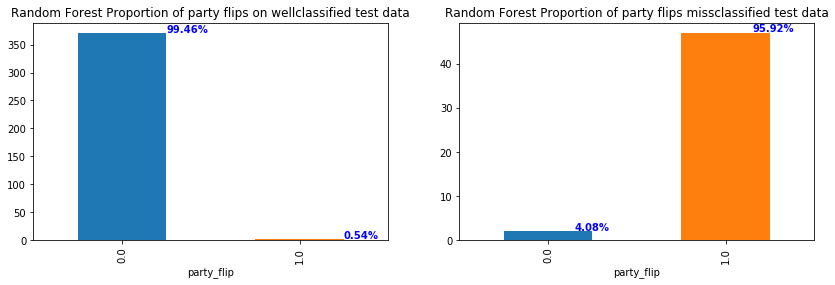

AdaBoost
Confusion Matrix: 
 [[193   3]
 [ 44 182]]

AdaBoost R2:  0.9923708920187794
AdaBoost Test Accuracy 0.8886255924170616
predicted correctly. does not flip.: 0.9946380697050938
predicted wrongly. does not flip.: 0.005361930294906166
predicted correctly. does flips.: 0.08163265306122448
predicted wrongly. does flips.: 0.9183673469387755


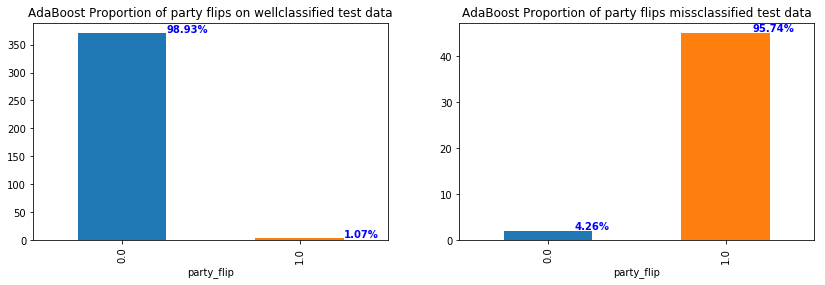

LASSO
Confusion Matrix: 
 [[195   1]
 [223   3]]

LASSO R2:  0.014441416351647971
LASSO Test Accuracy 0.46919431279620855
predicted correctly. does not flip.: 0.5201072386058981
predicted wrongly. does not flip.: 0.47989276139410186
predicted correctly. does flips.: 0.08163265306122448
predicted wrongly. does flips.: 0.9183673469387755


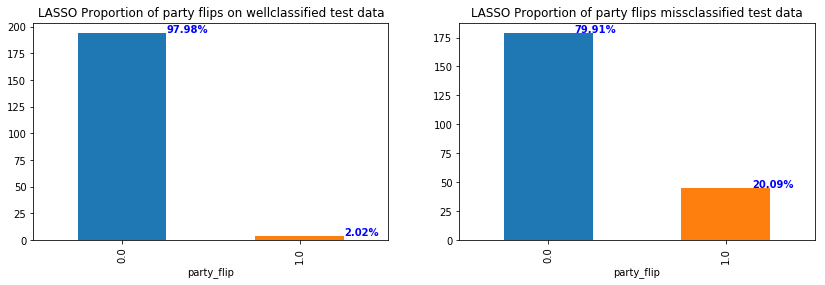

LASSO Betas
[('national_poll', -0.0), ('national_poll_prev', -0.0), ('national_poll_delta_subtract', 0.0), ('national_poll_delta_divide', -0.0), ('dem_win_margin_prev', 0.0), ('rep_win_margin_prev', -0.0), ('margin_signed_minus_prev', 0.0), ('margin_signed_divide_prev', 7.682723107299638e-11), ('margin_unsigned_minus_prev', 0.0), ('margin_unsigned_divide_prev', -3.795423245424468e-11), ('dem_win_prev', 0.0), ('rep_win_prev', -0.0), ('female_pct', 0.0), ('age18_24_pct', 0.0), ('age25_34_pct', 0.0), ('median_age', -0.0), ('unmarried_partner_pct', 0.0), ('male_living_alone_pct', 0.0), ('bachelors_deg_or_higher_pct', 0.0)]


In [70]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
#cols_to_use = [] # todo
state_hot_encoder = True

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

### Dataset since 2010, with demographics, dropping redistricted states

(1345, 19)
LogRegCV
Confusion Matrix: 
 [[187   0]
 [214   3]]

LogRegCV R2:  0.571003717472119
LogRegCV Test Accuracy 0.47029702970297027
predicted correctly. does not flip.: 0.5150684931506849
predicted wrongly. does not flip.: 0.4849315068493151
predicted correctly. does flips.: 0.05128205128205128
predicted wrongly. does flips.: 0.9487179487179487


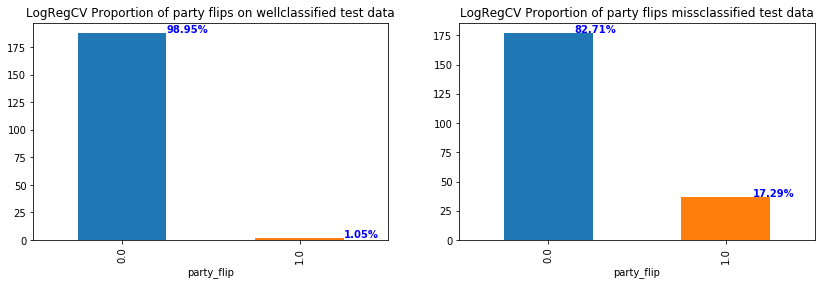

kNN
Confusion Matrix: 
 [[183   4]
 [ 41 176]]

kNN R2:  1.0
kNN Test Accuracy 0.8886138613861386
predicted correctly. does not flip.: 0.9780821917808219
predicted wrongly. does not flip.: 0.021917808219178082
predicted correctly. does flips.: 0.05128205128205128
predicted wrongly. does flips.: 0.9487179487179487


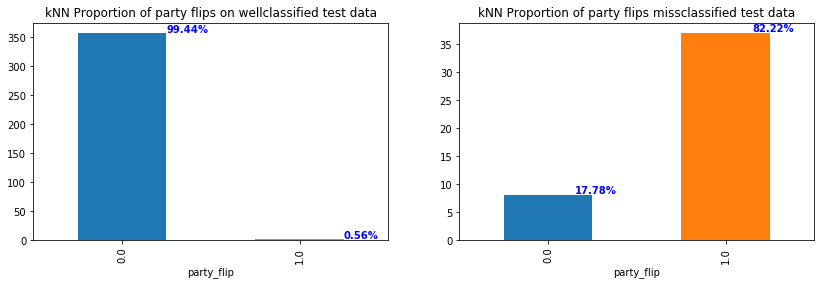

Random Forest
Confusion Matrix: 
 [[187   0]
 [ 39 178]]

Random Forest R2:  0.9970260223048327
Random Forest Test Accuracy 0.9034653465346535
predicted correctly. does not flip.: 0.9945205479452055
predicted wrongly. does not flip.: 0.005479452054794521
predicted correctly. does flips.: 0.05128205128205128
predicted wrongly. does flips.: 0.9487179487179487


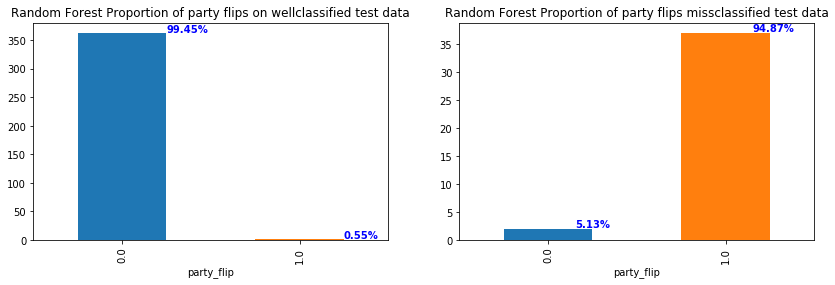

AdaBoost
Confusion Matrix: 
 [[184   3]
 [ 40 177]]

AdaBoost R2:  1.0
AdaBoost Test Accuracy 0.8935643564356436
predicted correctly. does not flip.: 0.9808219178082191
predicted wrongly. does not flip.: 0.019178082191780823
predicted correctly. does flips.: 0.07692307692307693
predicted wrongly. does flips.: 0.9230769230769231


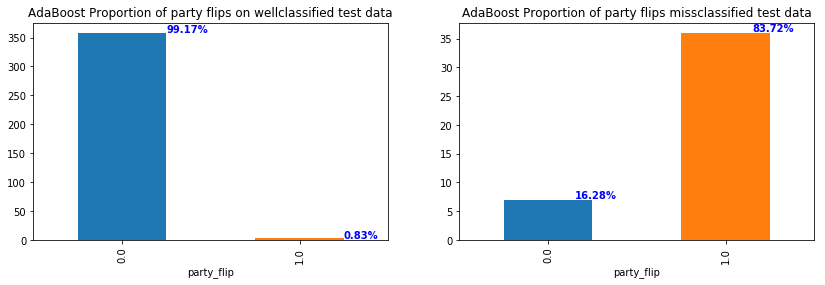

LASSO
Confusion Matrix: 
 [[187   0]
 [214   3]]

LASSO R2:  0.015840715608454903
LASSO Test Accuracy 0.47029702970297027
predicted correctly. does not flip.: 0.5150684931506849
predicted wrongly. does not flip.: 0.4849315068493151
predicted correctly. does flips.: 0.05128205128205128
predicted wrongly. does flips.: 0.9487179487179487


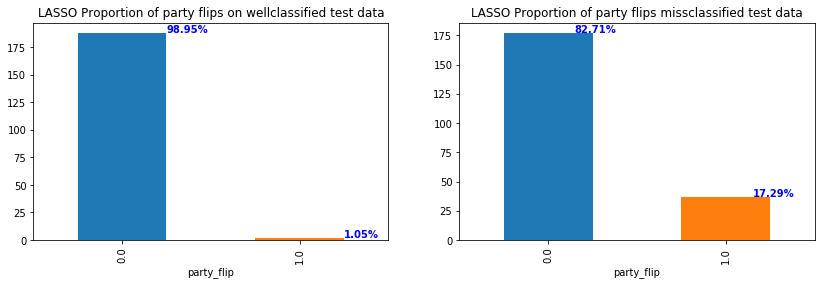

LASSO Betas
[('national_poll', -0.0), ('national_poll_prev', 0.0), ('national_poll_delta_subtract', -0.0), ('national_poll_delta_divide', 0.0), ('dem_win_margin_prev', 0.0), ('rep_win_margin_prev', -0.0), ('margin_signed_minus_prev', 0.0), ('margin_signed_divide_prev', 7.3362387123398e-11), ('margin_unsigned_minus_prev', 0.0), ('margin_unsigned_divide_prev', -3.799015300160527e-11), ('dem_win_prev', 0.0), ('rep_win_prev', -0.0), ('female_pct', 0.0), ('age18_24_pct', 0.0), ('age25_34_pct', 0.0), ('median_age', -0.0), ('unmarried_partner_pct', 0.0), ('male_living_alone_pct', 0.0), ('bachelors_deg_or_higher_pct', 0.0)]


In [71]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018_REDISTRICTDROP.p'
# cols_to_use same as above
state_hot_encoder = False

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

### Selected columns in dataset since 2010, with demographics, nothing dropped

In [ ]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
#cols_to_use = [] # todo
state_hot_encoder = True

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

### Selected columns in dataset since 2010, with demographics, dropping redistricted states

In [ ]:
# specify columns to use and the file you want to read in 

filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICS_2010_2018.p'
# same as before
state_hot_encoder = True

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

## Impute 2010 data into all non-redistricted districts in prior years. 

### Dataset since 2004, with demographics imputed, redistrited states dropped

(2603, 19)
LogRegCV
Confusion Matrix: 
 [[183   4]
 [ 35 182]]

LogRegCV R2:  0.9293123319247023
LogRegCV Test Accuracy 0.9034653465346535
predicted correctly. does not flip.: 0.9945205479452055
predicted wrongly. does not flip.: 0.005479452054794521
predicted correctly. does flips.: 0.05128205128205128
predicted wrongly. does flips.: 0.9487179487179487


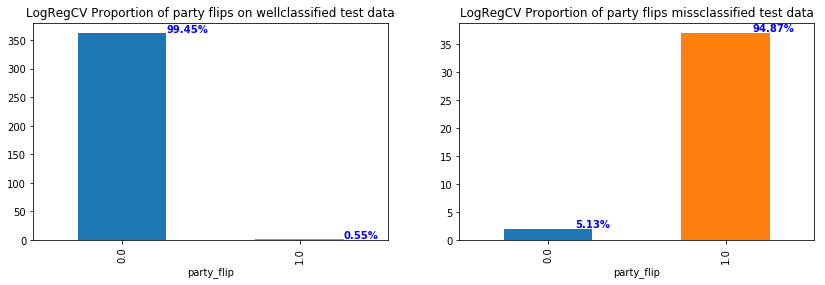

kNN
Confusion Matrix: 
 [[174  13]
 [ 37 180]]

kNN R2:  1.0
kNN Test Accuracy 0.8762376237623762
predicted correctly. does not flip.: 0.9616438356164384
predicted wrongly. does not flip.: 0.038356164383561646
predicted correctly. does flips.: 0.07692307692307693
predicted wrongly. does flips.: 0.9230769230769231


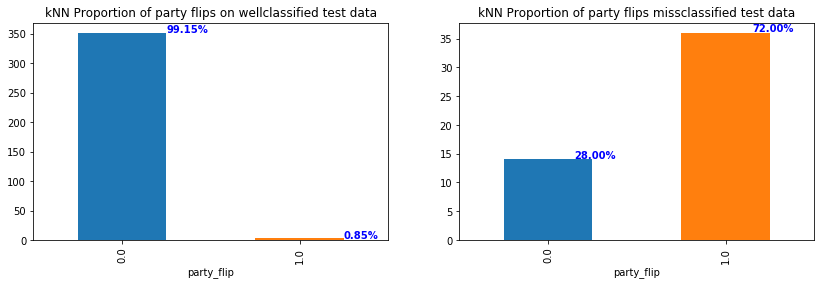

Random Forest
Confusion Matrix: 
 [[184   3]
 [ 36 181]]

Random Forest R2:  0.9942374183634268
Random Forest Test Accuracy 0.9034653465346535
predicted correctly. does not flip.: 0.9972602739726028
predicted wrongly. does not flip.: 0.0027397260273972603
predicted correctly. does flips.: 0.02564102564102564
predicted wrongly. does flips.: 0.9743589743589743


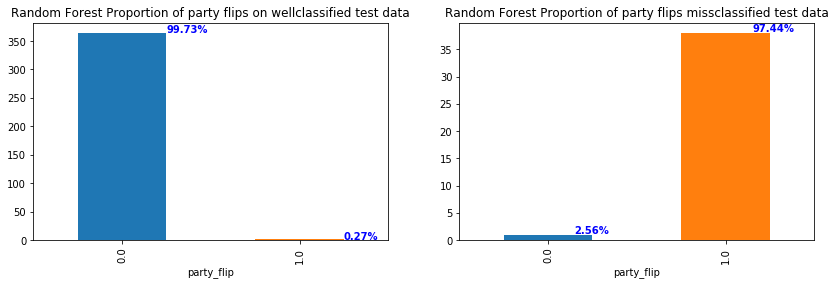

AdaBoost
Confusion Matrix: 
 [[168  19]
 [ 33 184]]

AdaBoost R2:  0.9857856319631195
AdaBoost Test Accuracy 0.8712871287128713
predicted correctly. does not flip.: 0.947945205479452
predicted wrongly. does not flip.: 0.052054794520547946
predicted correctly. does flips.: 0.15384615384615385
predicted wrongly. does flips.: 0.8461538461538461


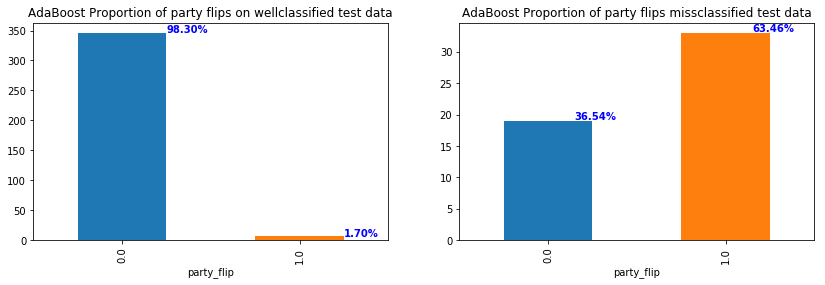

LASSO
Confusion Matrix: 
 [[187   0]
 [214   3]]

LASSO R2:  0.025571370567853635
LASSO Test Accuracy 0.47029702970297027
predicted correctly. does not flip.: 0.5150684931506849
predicted wrongly. does not flip.: 0.4849315068493151
predicted correctly. does flips.: 0.05128205128205128
predicted wrongly. does flips.: 0.9487179487179487


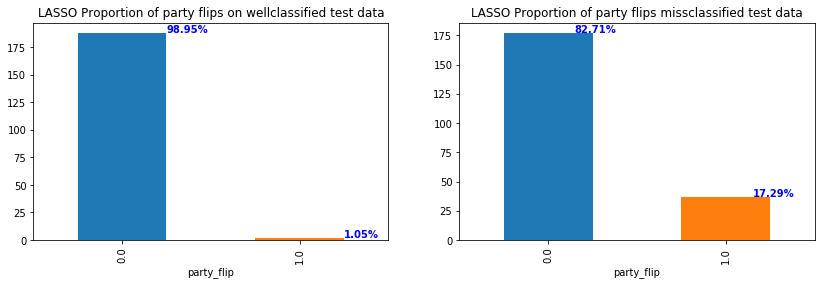

LASSO Betas
[('national_poll', 0.0), ('national_poll_prev', 0.0), ('national_poll_delta_subtract', 0.0), ('national_poll_delta_divide', 0.0), ('dem_win_margin_prev', 0.0), ('rep_win_margin_prev', -0.0), ('margin_signed_minus_prev', 0.0), ('margin_signed_divide_prev', 9.47203097821942e-11), ('margin_unsigned_minus_prev', 0.0), ('margin_unsigned_divide_prev', -4.8214425963177477e-11), ('dem_win_prev', 0.0), ('rep_win_prev', -0.0), ('female_pct', 0.0), ('age18_24_pct', 0.0), ('age25_34_pct', 0.0), ('median_age', -0.0), ('unmarried_partner_pct', 0.0), ('male_living_alone_pct', 0.0), ('bachelors_deg_or_higher_pct', 0.0)]


In [73]:
filename = 'Datasets/data_FEC_NATIONALPOLL_DEMOGRAPHICSIMPUTED_2004_2018_REDISTRICTDROP.p'
#cols = [] # todo
state_hot_encoder = True

fitted_models = report_model_stats(filename, cols_to_use, model_dict, state_hot_encoder)

Idea: variable which is # of tims a district flipped in prior years... or something

## Try different k's for kNN 

In [ ]:
#Try KNN
k_values =[1,3,5,10,25,100,500]
k_score = []
k_test_accuracy =[]
k_models =[]

for i in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=i,n_jobs=4)
    knn_model.fit(X_train,y_train)
    k_models.append(knn_model)
    k_score.append(knn_model.score(X_train,y_train))
    y_pred_test = knn_model.predict(X_test)
    k_test_accuracy.append(accuracy_score(y_test,y_pred_test))
    
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(k_values,k_score)
ax[1].scatter(k_values,k_test_accuracy)
ax[0].set_xticklabels(k_values)

ax[0].set_title("R2score vs. K")
ax[1].set_title("Test Accuracy vs. K")

ax[0].set_xlabel("K values")
ax[0].set_ylabel("r2_score")
ax[1].set_xlabel("K values")
ax[1].set_ylabel("Test Accuracy")  
print("\n")

###  NOTES:

1. Logistic CV 90% of the missclassified data occurs when there is a change of party compared to the previous year. No state flips are predicted correctly. 
2. KNN, 100% of the missclassified data occurs when there is a change of party. 5% of the well classified data is party flip. (Better performance)
3. Predicts correctly 100% of the districts that do not change, and ...

Concentrate on improving the states that flip to a different party between elections

Ideas
0. Try non-linear approaches (KNN, Random Forest and Boosting)
1. Increase data by Upsampling and downsampling
2. Increase data by adding more historical data
3. Add demographics data
4. Add redistricting